In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

import torch
from torch import nn

import os
import sys
import glob
import pickle

In [3]:
SEED = 52
torch.manual_seed(SEED)

In [4]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print("Python interpreter path:")
for path in sys.path:
    print(path)

Notebook dir /home/manifold/Documents/etudes/map511-p3a
Python interpreter path:
/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload

/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


# Loading synthetic data

We will be loading simulated Hawkes data.

In [119]:
SYNTH_DATA_FILES = glob.glob('../data/simulated/*.pkl')
print("Available files:")
for s in SYNTH_DATA_FILES:
    print(s)

from utils.load_synth_data import process_loaded_sequences, one_hot_embedding

Available files:
../data/simulated/hawkes_synthetic_exp_1d_20181205-142133.pkl
../data/simulated/hawkes_synthetic_exp_2d_20181201-002801.pkl


In [120]:
# SET THESE PARAMETERS
process_dim = 1
print("Process dimension: {}".format(process_dim))
choose_file_index = 0
chosen_data_file = SYNTH_DATA_FILES[choose_file_index]
print("Data file: {}".format(chosen_data_file))

Process dimension: 1
Data file: ../data/simulated/hawkes_synthetic_exp_1d_20181205-142133.pkl


In [121]:
# Load data simulated using tick
print("Loading {}-dimensional Hawkes data.".format(process_dim))

with open(chosen_data_file, "rb") as f:
    loaded_hawkes_data = pickle.load(f)

print(loaded_hawkes_data.keys())

mu = loaded_hawkes_data['mu']
alpha = loaded_hawkes_data['alpha']
decay = loaded_hawkes_data['decay']
tmax = loaded_hawkes_data['tmax']
print("mu\t{:}".format(str(mu)))
print("alpha\t{:}".format(str(alpha)))
print("decay\t{:}".format(str(decay)))
print("tmax\t{:}".format(tmax))

seq_times, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data, process_dim, tmax)

Loading 1-dimensional Hawkes data.
dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])
mu	0.2
alpha	0.1
decay	2.0
tmax	3600.0


# Neural network

In [11]:
from models.decayrnn import HawkesDecayRNN, HawkesRNNGen

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = f\left(W_{\lambda} h(t)\right)
$$

with $f$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

Network update formulas: the jump and decay parameters on $(t_i,t_{i+1}]$ are given by
$$
\begin{align*}
    h_{i+1}      &= \tanh(W_{hh}h(t_i) + W_{xh}x_i + b_{h}) \\
    \delta_{i+1} &= f(W_{hd} h(t_i) + W_{xd}x_i + b_{d})
\end{align*}
$$

In [185]:
from train_functions import train_decayrnn, plot_loss

In [186]:
# define training data
train_size = 3000
print("Train size %d" % train_size)

train_times_tensor = seq_times[:train_size]
train_seq_types = seq_types[:train_size]
train_seq_lengths = seq_lengths[:train_size]
print("Train event times shape {}".format(train_times_tensor.shape))
print("Train event types shape {}".format(train_seq_types.shape))
print("Train seq lengths shape {}".format(train_seq_lengths.shape))

Train size 3000
Train event times shape torch.Size([3000, 158])
Train event types shape torch.Size([3000, 158])
Train seq lengths shape torch.Size([3000])


In [187]:
process_dim = 1
hidden_size = 32
model = HawkesDecayRNN(process_dim, hidden_size)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.021)

# Training parameters
BATCH_SIZE = 32
EPOCHS = 20

loss_hist, train_hist = train_decayrnn(
    model, optimizer, train_times_tensor,
    train_seq_types, train_seq_lengths, tmax,
    BATCH_SIZE, EPOCHS, use_jupyter=True)

Batch size 32
Number of epochs 20
Train size: 3000


epoch 1: train loss 75.3583


epoch 2: train loss 73.1276


epoch 3: train loss 73.0070


epoch 4: train loss 72.9798


epoch 5: train loss 72.9210


epoch 6: train loss 72.8862


epoch 7: train loss 72.8575


epoch 8: train loss 72.8704


epoch 9: train loss 72.8076


epoch 10: train loss 72.8460


epoch 11: train loss 72.7967


epoch 12: train loss 72.7633


epoch 13: train loss 72.7773


epoch 14: train loss 72.7504


epoch 15: train loss 72.7343


epoch 16: train loss 72.7345


epoch 17: train loss 72.7300


epoch 18: train loss 72.7261


epoch 19: train loss 72.6996


epoch 20: train loss 72.6911


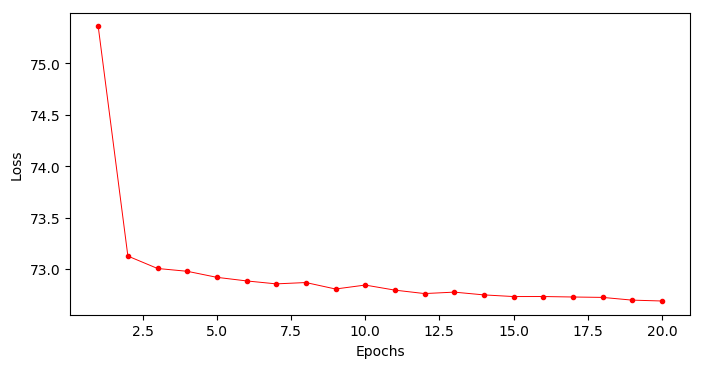

In [188]:
_ = plot_loss(EPOCHS, loss_hist)

In [189]:
import datetime
# Generate save params to record the model
# Model file dump
SAVED_MODELS_PATH = '../saved_models'
os.makedirs(SAVED_MODELS_PATH, exist_ok=True)
# print("Saved models directory: {}".format(SAVED_MODELS_PATH))

In [190]:
# This cell resets the timestamp !!
date_format = "%Y%m%d-%H%M%S"
now_timestamp = datetime.datetime.now().strftime(date_format)
extra_tag = "{}d".format(process_dim)

In [191]:
train_hist[-1].keys()

dict_keys(['hidden', 'decay'])

Now we save the model down to a file, and record the data files on which it was trained.

In [193]:
import json

filename_base = "{}-{}_hidden{}-{}".format(
    model.__class__.__name__, extra_tag,
    hidden_size, now_timestamp)
filename_model_save = filename_base + ".pth"
model_filepath = os.path.join(SAVED_MODELS_PATH, filename_model_save)
print("Model save file path: {}".format(model_filepath))

Model save file path: ../saved_models/HawkesDecayRNN-1d_hidden32-20181202-141923.pth


In [194]:
file_correspondance = {
    "model_path": model_filepath,
    "data_path": chosen_data_file
}
print(file_correspondance)

{'model_path': '../saved_models/HawkesDecayRNN-1d_hidden32-20181202-141923.pth', 'data_path': '../data/simulated/hawkes_synthetic_exp_1d_20181202-135203.pkl'}


In [195]:
with open(os.path.join(SAVED_MODELS_PATH, "train_data_correspondance.jsonl"), "a") as f:
    json.dump(file_correspondance, f)

print("Saving model state dict to {}".format(model_filepath))
torch.save(model.state_dict(), model_filepath)

Saving model state dict to ../saved_models/HawkesDecayRNN-1d_hidden32-20181202-141923.pth


# Model evaluation

In [55]:
tmax = 3600

Let us load up a model

In [67]:
from models.decayrnn import HawkesDecayRNN, HawkesRNNGen

In [68]:
MODEL_FILES = glob.glob("../saved_models/*.pth")
for p in MODEL_FILES:
    print(p)

../saved_models/HawkesDecayRNN-1d_hidden32-20181205-230630.pth


In [69]:
load_filename = MODEL_FILES[0]
print("chosen file:", load_filename)

load_file_timestamp = "-".join(os.path.splitext(os.path.basename(load_filename))[0].split('-')[-2:])
print(load_file_timestamp)

chosen file: ../saved_models/HawkesDecayRNN-1d_hidden32-20181205-230630.pth
20181205-230630


In [70]:
process_dim = 1
hidden_size = 32
print("Hidden size: {}".format(hidden_size))
model = HawkesDecayRNN(process_dim, hidden_size)

model.load_state_dict(torch.load(load_filename, map_location={"cuda:0": "cpu"}))

Hidden size: 32


## Sequence generation

### Untrained model, random weights

In [71]:
print("Real end time: {}".format(tmax))

Real end time: 3600


In [81]:
raw_model = HawkesDecayRNN(2, hidden_size)
generator_base = HawkesRNNGen(raw_model)

Process model dim:	2	Hidden units:	32


no. of events: 9
0: type 0
1: type 1


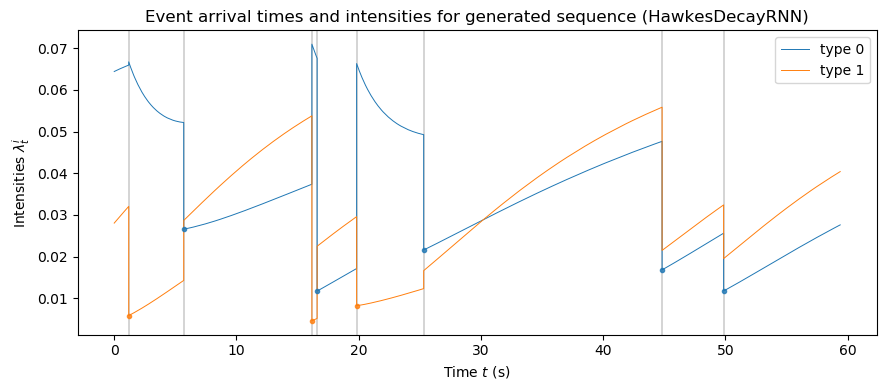

In [83]:
tmax_simu = 60
generator_base.generate_sequence(tmax_simu, record_intensity=True)

fig = generator_base.plot_events_and_intensity(debug=False)
fig.tight_layout()

In [96]:
generator_base.generate_sequence(tmax)

In [97]:
print(len(generator_base.event_times))
print(len(generator_base._plot_times))

281
1146


#### On trained model

In [98]:
RESULT_BASEDIR = "../results"
extra_tag = "{}d".format(process_dim)

MODEL_NAME = model.__class__.__name__
print(MODEL_NAME)

HawkesDecayRNN


In [99]:
generator = HawkesRNNGen(model, record_intensity=False)

Process model dim:	1	Hidden units:	32


no. of events: 29
0: type 0


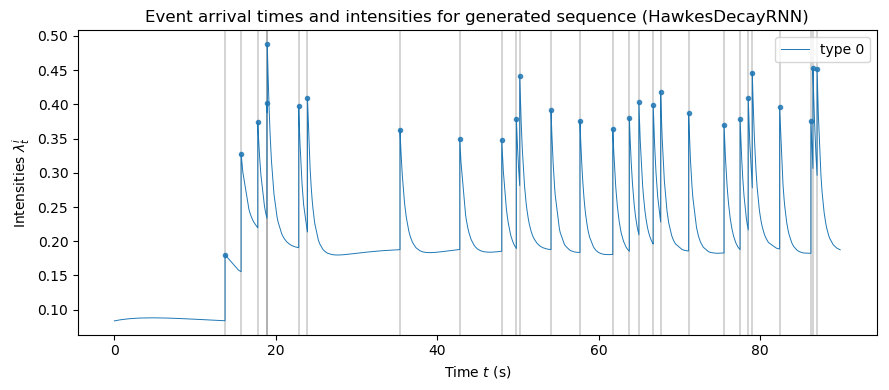

In [100]:
tmax_simu = 90
generator.generate_sequence(tmax_simu, record_intensity=True)
fig_intensity_stream = generator.plot_events_and_intensity()

In [101]:
fig_intensity_stream.savefig("../results/intensity_{}_{}_hidden{}_{}.pdf".format(
    MODEL_NAME, extra_tag, hidden_size, load_file_timestamp))

In [25]:
generator.record_intensity = False

### Sequence length distribution

In [134]:
generator.generate_sequence(tmax)

In [135]:
len(generator.event_times)

773

In [123]:
# Build a statistic for the no. of events
gen_seq_lengths = []
gen_seq_types_lengths = []
n_gen_seq = 500 # number of generated sequences
for i in range(n_gen_seq):
    generator.generate_sequence(tmax, record_intensity=False)
    gen_seq_times = generator.event_times
    gen_seq_types = np.array(generator.event_types)
    gen_seq_lengths.append(len(gen_seq_times))
    gen_seq_types_lengths.append([
        (gen_seq_types == i).sum() for i in range(model.input_size)
    ])
gen_seq_lengths = np.array(gen_seq_lengths)
gen_seq_types_lengths = np.array(gen_seq_types_lengths)

print("Mean generated sequence length: {}".format(gen_seq_lengths.mean()))
print("Generated sequence length std. dev: {}".format(gen_seq_lengths.std()))

KeyboardInterrupt: 

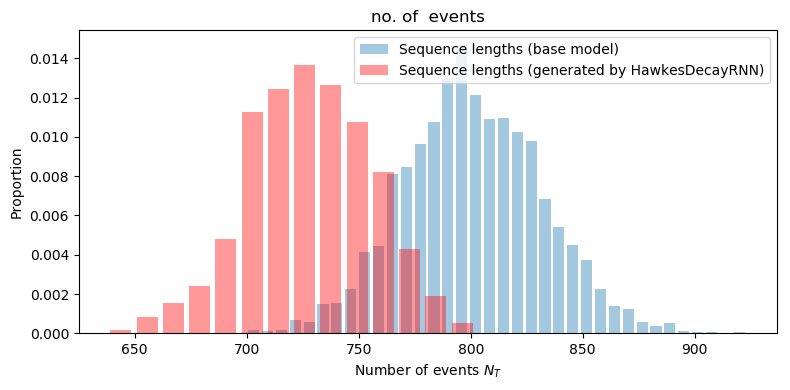

In [122]:
if process_dim > 1:
    num_plots = process_dim + 1
else:
    num_plots = 1
fig, axes = plt.subplots(num_plots, 1, figsize=(8,4+(num_plots-1)*3), dpi=100)
ax0 = axes[0] if num_plots > 1 else axes
hist_opts = {
    "rwidth": 0.8,
    "alpha": 0.4,
    "density": True
}
gen_label = "Sequence lengths (generated by {:})".format(MODEL_NAME)
_ = ax0.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(1/3)),
            label="Sequence lengths (base model)",
            **hist_opts)
_ = ax0.hist(gen_seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label=gen_label,
            color='red', **hist_opts)
ax0.legend()
if num_plots > 1:
    ax0.set_title('no. of events (all types, including starter type)')
else:
    ax0.set_title('no. of  events')
ax0.set_ylabel('Proportion')
ax0.set_xlabel('Number of events $N_T$')
if num_plots > 1:
    axt = axes[1:]
    for i, ax in enumerate(axt):
        # get the sequence lengths for the event types
        typ_seq_lengths = (seq_types == i).sum(dim=1)
        gen_typ_seq_lengths = gen_seq_types_lengths[:, i]
        ax.hist(typ_seq_lengths, bins=2*int(typ_seq_lengths.size(0)**(1/3)),
                label="Sequence lengths (base model)",
                **hist_opts)
        ax.hist(gen_typ_seq_lengths,
                bins=2*int(gen_typ_seq_lengths.shape[0]**(1/3)),
                label=gen_label,
                color='red', **hist_opts)
        ax.set_xlabel("Number of events of type {}, $N_T^{}$".format(i, i))
        ax.set_title('no. of events of type $i={}$'.format(i))

fig.tight_layout()

In [123]:
os.makedirs(RESULT_BASEDIR, exist_ok=True)
model_perf_indicator = "seq_length_distrib"
distrib_plot_filepath = "{:}/{:}_{:}-{}-hidden_{}-{}.pdf".format(
    RESULT_BASEDIR, model_perf_indicator, MODEL_NAME,
    extra_tag, model.hidden_size, load_file_timestamp)
fig.savefig(distrib_plot_filepath)